# CEIA - VISIÓN POR COMPUTADORA
## TP2 - Integrantes
###
* Ruiz Otondo, Juan
* Torres, Dimas
* Villanueva, Cecilia Azul

## **Objetivo**
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.



2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure
operators in shapefrom focus.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

In [14]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### 1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos. Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

#### Funciones

In [15]:
# Función para mostrar una imagen
def showImage(imagen, titulo='Imagen'):
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [16]:
def extractROI(image, roi_fraction=0.1):
    # Extrae una región de interés (ROI) central que cubre una fracción dada del frame.
    
    height, width = image.shape

    area=roi_fraction*height*width

    # Calculate ROI dimensions
    roi_width  = int(np.sqrt(area * (width / height)))
    roi_height = int(area / roi_width)
    
    # Center coordinates
    center_x, center_y = width // 2, height // 2
    
    # Calculate ROI bounds
    x_start = center_x - roi_width // 2
    y_start = center_y - roi_height // 2
    x_end = center_x + roi_width // 2
    y_end = center_y + roi_height // 2
    
    # Extract and return the ROI
    return image[y_start:y_end, x_start:x_end],[(x_start, y_start), (x_end, y_end)]

In [17]:
# Función para calcular la métrica de enfoque de una imagen (image_quality_measure)
def getISM(frame_gris):
    # Paso 1: Transformada de Fourier centrada
    f_transformada = np.fft.fft2(frame_gris)
    f_transformada_centrada = np.fft.fftshift(f_transformada)

    # Paso 2: Obtener espectro de magnitud
    espectro_magnitud = np.abs(f_transformada_centrada)

    # Paso 3: Calcular el valor máximo y definir el umbral
    valor_max = np.max(espectro_magnitud)
    umbral = valor_max / 1000  # Definir umbral como M / 1000

    # Paso 4: Contar los píxeles que superan el umbral
    componentes_alta_frecuencia = np.sum(espectro_magnitud > umbral)

    # Calcular la métrica de enfoque (proporción de componentes de alta frecuencia)
    fm = componentes_alta_frecuencia / (frame_gris.shape[0] * frame_gris.shape[1])
    return fm

In [18]:
def showIMQ(metrics,percentile,title):
    # Calculate the threshold value
    threshold= np.percentile(metrics, percentile)

    # Plot
    plt.figure(figsize=(10, 6))

    # Focus metrics plot
    plt.plot(metrics, marker='o', linestyle='-', color='b', label='Métricas de enfoque')

    # Threshold line
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Percentil {percentile}% = {threshold:.2f}')

    # Frames above the threshold
    plt.scatter([i for i, m in enumerate(metrics) if m >= threshold], 
                [m for m in metrics if m >= threshold], 
                color='g', zorder=5, label=f'Frames arriba del percentil {percentile}%')

    # Title and labels
    plt.xlabel('Frame #')
    plt.ylabel('ISM')
    plt.title(title)
    plt.legend(loc='upper left')

    # show plot
    plt.grid(True)
    plt.show()


In [19]:
# Función para calcular la métrica de enfoque de un video
def focus_measure(video_path, roi_fraction):

    captura_video = cv.VideoCapture(video_path)

    metricas_enfoque = []  # Almacenar métricas de cada frame

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        # Procesar cada frame del video
   
        while True:
            ret, frame = captura_video.read()
            if not ret:
                break

            # Convertir a escala de grises
            frame_gris = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            
            img,pts=extractROI(frame_gris,roi_fraction)
           
            # Calcular la métrica de enfoque
            fm = getISM(img)
            metricas_enfoque.append(fm)

    # Libera el objeto de captura de video
    captura_video.release()
    cv.destroyAllWindows()

    return metricas_enfoque, pts

In [20]:
def process_video(video_path, roi_fraction=0.1, percentile=90):
    
    # Calcular la métrica de enfoque
    metricas_enfoque,pts = focus_measure(video_path, roi_fraction)

    if roi_fraction==1:
          title= f'ISM sobre Frames' 
    else: title= f'ISM sobre ROI {roi_fraction*100}% area'

    # Mostrar las métricas de enfoque
    showIMQ(metricas_enfoque, percentile,title)

    foco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

    showVideo(video_path,title,pts,foco)
    

In [21]:
def printFrameNum(img, num, c, s):
    """
    Agrega el número de frame
    """
    cv.putText(img, f'FRAME {num}', (30, 30), cv.FONT_HERSHEY_SIMPLEX, s, c, 2, cv.LINE_AA)

    return img

In [22]:
def printRectangle(img, pt1, pt2, c, s):
    """
    Agregar rectángulo del área de interés
    """
    pt2_a= tuple(x - 1 for x in pt2)
    
    cv.rectangle(img, pt1, pt2_a, c, s, cv.LINE_8)

    return img

In [23]:
def showVideo(path,title,pts,lista):
    """
    Muestra el video
    incluyendo la señalización indicada
    en las propiedades
    """
    
    try:    
        video_capture = cv.VideoCapture(path)
        timer=0
        
        if not video_capture.isOpened():
            print("Error al abrir el archivo de video")
        else:
            # tasa de cuadros (frame rate) del video
            fps = int(video_capture.get(cv.CAP_PROP_FPS))
            normal_delay = int(1000 / fps)
            delay = normal_delay    
            
            i=0
            
            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break
              
                
                if lista[i]:
                    color= (0, 255, 0)
                    delay = normal_delay * 5
                else:
                    color = (0, 0, 255)
                  
                    delay = normal_delay


                # Imprime frame original sin alterar por default
                new_frame = frame

                # Agrega modificaciones al frame según los parámetros de entrada
                printFrameNum(new_frame, i, color, 1)

                printRectangle(new_frame, pts[0], pts[1], color, 2)

                cv.imshow(title, new_frame)
                
                i = i + 1
                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break
    finally:    
        # Liberar recursos
        video_capture.release()
        cv.destroyAllWindows()

#### 1.1 - Medición sobre todo el frame.

In [9]:
# Abre el video
video_path = './focus_video.mov'


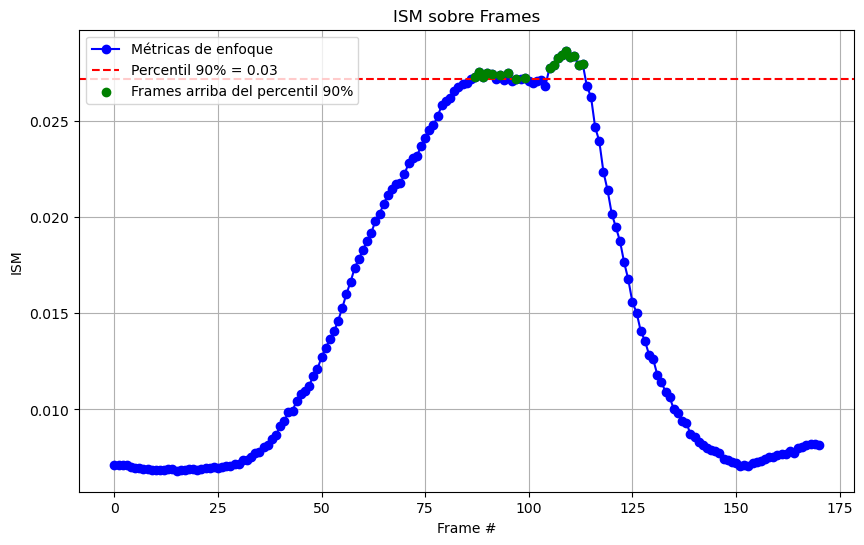

In [17]:
#Medicion sobre todo el Frame con percentil 90% para máximo enfoque.
process_video(video_path,1,90)


#### 1.2 - Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

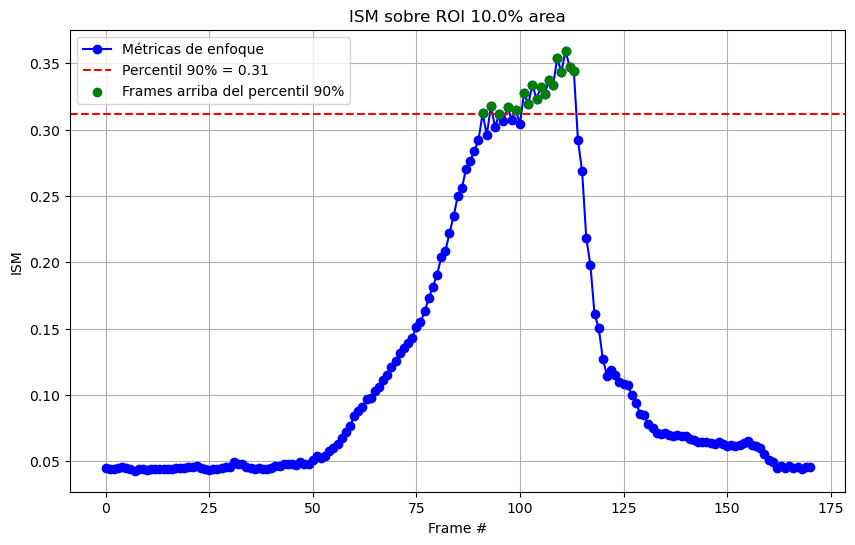

In [18]:
# Medicion sobre una ROI del 10% con percentil 90% para máximo enfoque.
process_video(video_path,0.1,90)

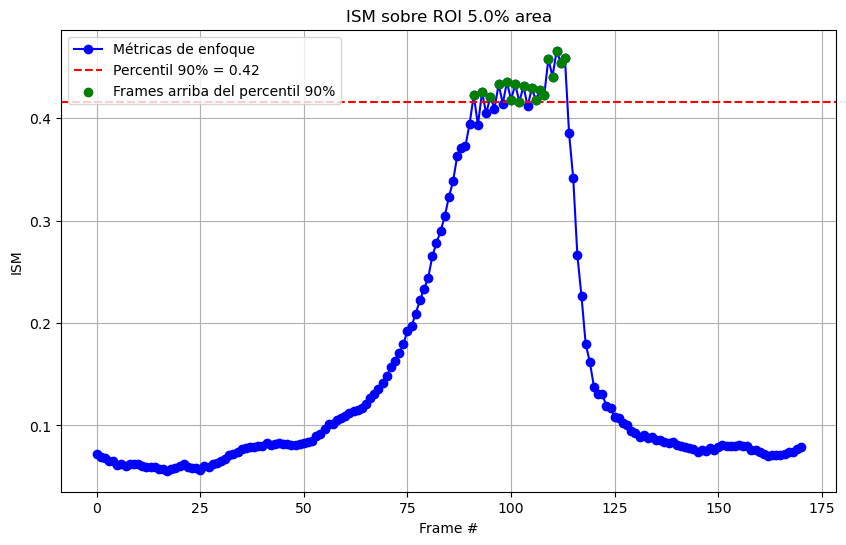

In [19]:
# Medicion sobre una ROI del 10% con percentil 90% para máximo enfoque.
process_video(video_path,0.05,90)

#### 1.3 Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

In [41]:
#TODO: Implementar

### 2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

In [29]:
def getLap4(imagen, tamaño_ventana):
    """
    Calcula la medida de enfoque LAP4 (varianza del Laplaciano) en una imagen.

    Args:
      imagen: La imagen de entrada en escala de grises.
      tamaño_ventana: El tamaño de la ventana para calcular el Laplaciano (debe ser un número impar).

    Returns:
      La medida de enfoque LAP4.
    """

    # Verificar si la imagen está en escala de grises
    if len(imagen.shape) > 2:
        raise ValueError("La imagen debe estar en escala de grises.")

    # Verificar si el tamaño de la ventana es impar
    if tamaño_ventana % 2 == 0:
        raise ValueError("El tamaño de la ventana debe ser un número impar.")

    # Calcular el Laplaciano de la imagen
    laplaciano = cv.Laplacian(imagen, cv.CV_64F, ksize=tamaño_ventana)

    # Calcular la varianza del Laplaciano en la ventana
    varianza_laplaciano = np.var(laplaciano)

    return varianza_laplaciano

In [30]:
# Función para calcular la métrica de enfoque de un video
def focus_measure_lap4(video_path,window_size,roi_fraction):

    captura_video = cv.VideoCapture(video_path)

    metricas_enfoque = []  # Almacenar métricas de cada frame

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        # Procesar cada frame del video
   
        while True:
            ret, frame = captura_video.read()
            if not ret:
                break

            # Convertir a escala de grises
            frame_gris = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            
            img,pts=extractROI(frame_gris,roi_fraction)
           
            # Calcular la métrica de enfoque
            fm = getLap4(img,window_size)
            metricas_enfoque.append(fm)

    # Libera el objeto de captura de video
    captura_video.release()
    cv.destroyAllWindows()

    return metricas_enfoque, pts

In [31]:
def process_video_lap4(video_path, roi_fraction=0.1, percentile=90,window_size=3):
    
    # Calcular la métrica de enfoque
    metricas_enfoque,pts = focus_measure_lap4(video_path,window_size, roi_fraction)

    if roi_fraction==1:
          title= f'LAP4 sobre Frames' 
    else: title= f'LAP4 sobre ROI {roi_fraction*100}% area'

    # Mostrar las métricas de enfoque
    showIMQ(metricas_enfoque, percentile,title)

    enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

    showVideo(video_path,title,pts,enfoco)

#### 2.1 Medicion sobre Frames

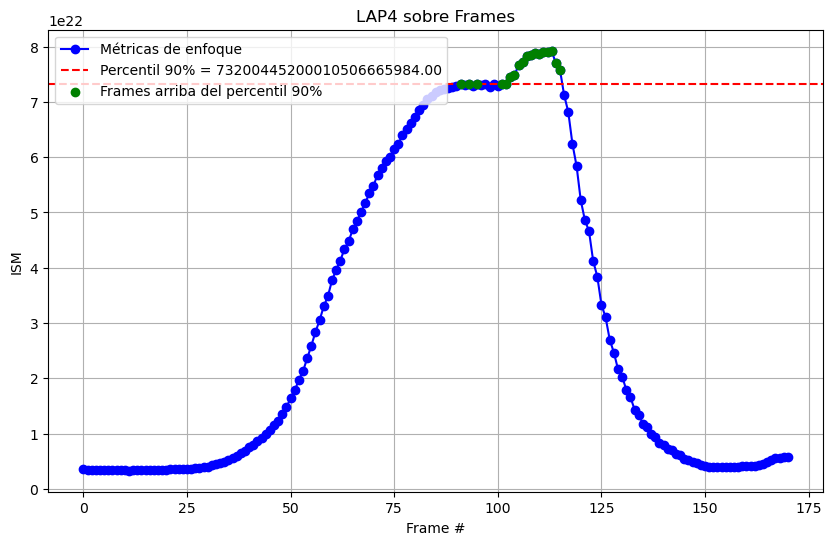

In [32]:
process_video_lap4(video_path,1,90,21)

#### 2.2 Medicion sobre una ROI

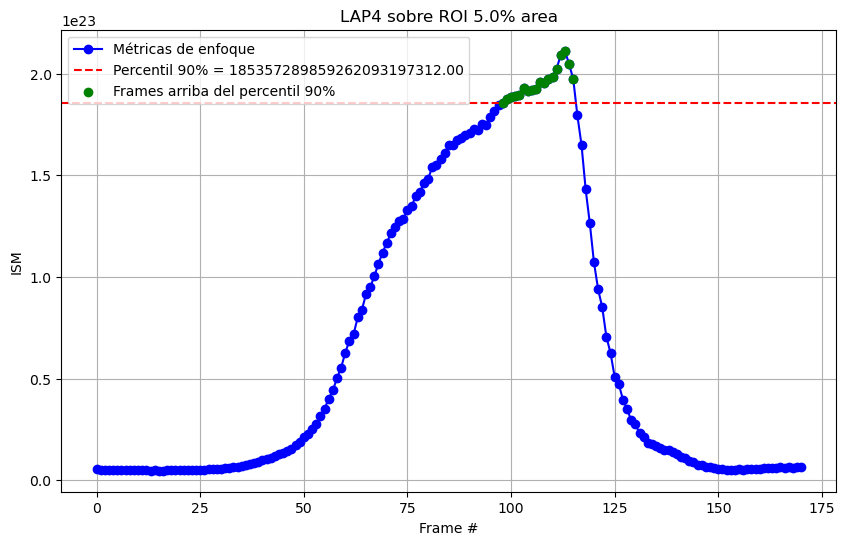

In [33]:
process_video_lap4(video_path,0.05,90,21)

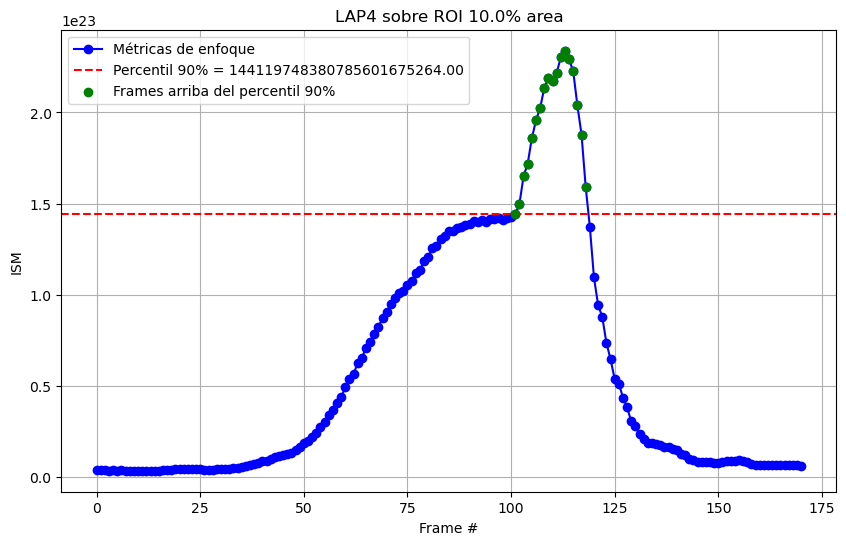

In [34]:
process_video_lap4(video_path,0.1,90,21)

#### 2.3 Medicion sobre una matriz

In [40]:
#TODO: Implementar

### Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [39]:
#TODO: Implementar

El resultado es muy similar al obtenido con el método en el dominio de frecuencias.

In [37]:
def detectar_maximo_enfoque(metricas_enfoque, umbral_derivada=0.001, longitud_ventana=5):
    """
    Detecta el punto de máximo enfoque en una lista de métricas de enfoque.

    Args:
      metricas_enfoque: Una lista de valores de métrica de enfoque.
      umbral_derivada: Umbral para la derivada de la métrica de enfoque.
      longitud_ventana: Longitud de la ventana para calcular la derivada.

    Returns:
      El índice del frame con el máximo enfoque.
    """

    # Calcular la derivada de la métrica de enfoque
    derivada = np.gradient(metricas_enfoque)

    # Buscar el punto donde la derivada cruza el umbral
    indice_maximo = None
    for i in range(longitud_ventana, len(derivada) - longitud_ventana):
        # Verificar si la derivada es mayor que el umbral en la ventana
        if all(derivada[j] > umbral_derivada for j in range(i - longitud_ventana, i)) and \
           all(derivada[j] < -umbral_derivada for j in range(i, i + longitud_ventana)):
            indice_maximo = i
            break

    return indice_maximo